## About Dataset

Context This is a small subset of dataset of Book reviews from Amazon Kindle Store category.

Content 5-core dataset of product reviews from Amazon Kindle Store category from May 1996 - July 2014. Contains total of 982619 entries. Each reviewer has at least 5 reviews and each product has at least 5 reviews in this dataset. Columns

- asin - ID of the product, like B000FA64PK
- helpful - helpfulness rating of the review - example: 2/3.
- overall - rating of the product.
- reviewText - text of the review (heading).
- reviewTime - time of the review (raw).
- reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN
- reviewerName - name of the reviewer.
- summary - summary of the review (description).
- unixReviewTime - unix timestamp.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, 
    recall_score, classification_report, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

## Reading and Understanding Dataset

In [2]:
df = pd.read_csv('data/all_kindle_review.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [3]:
df = df[['reviewText', 'rating']]
df.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [4]:
df.shape

(12000, 2)

In [5]:
df.isnull().sum()

reviewText    0
rating        0
dtype: int64

In [6]:
df['rating'].unique()

array([3, 5, 4, 2, 1], dtype=int64)

In [7]:
df['rating'].value_counts()

rating
5    3000
4    3000
3    2000
2    2000
1    2000
Name: count, dtype: int64

## Data Cleaning and Preprocessing

In [8]:
df['rating'] = df['rating'].apply(lambda x: 0 if x < 3 else 1)
df.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",1
1,Great short read. I didn't want to put it dow...,1
2,I'll start by saying this is the first of four...,1
3,Aggie is Angela Lansbury who carries pocketboo...,1
4,I did not expect this type of book to be in li...,1


In [9]:
df['rating'].unique()

array([1, 0], dtype=int64)

In [10]:
df['rating'].value_counts()

rating
1    8000
0    4000
Name: count, dtype: int64

### Converting text to lower case

In [11]:
df['reviewText'] = df['reviewText'].str.lower()
df.head()

,reviewText,rating
0,"jace rankin may be short, but he's nothing to ...",1
1,great short read. i didn't want to put it dow...,1
2,i'll start by saying this is the first of four...,1
3,aggie is angela lansbury who carries pocketboo...,1
4,i did not expect this type of book to be in li...,1


### Removing Special Characters

In [12]:
df['reviewText'] = df['reviewText'].apply(lambda x:re.sub('[^a-z A-z 0-9-]+', '',x))

### Removing Stopwords

In [13]:
df['reviewText'] = df['reviewText'].apply(lambda x:" ".join([y for y in x.split() if y not in stopwords.words('english')]))

### Removing URLs

In [14]:
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))

### Removing HTML Tags

In [15]:
df['reviewText'] = df['reviewText'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

### Removing Additional Spaces

In [16]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.split()))

In [17]:
df.head()

,reviewText,rating
0,jace rankin may short hes nothing mess man hau...,1
1,great short read didnt want put read one sitti...,1
2,ill start saying first four books wasnt expect...,1
3,aggie angela lansbury carries pocketbooks inst...,1
4,expect type book library pleased find price right,1


## Lemmatizer

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [20]:
df['reviewText'] = df['reviewText'].apply(lambda x:lemmatize_words(x))

In [21]:
df.head()

,reviewText,rating
0,jace rankin may short he nothing mess man haul...,1
1,great short read didnt want put read one sitti...,1
2,ill start saying first four book wasnt expecti...,1
3,aggie angela lansbury carry pocketbook instead...,1
4,expect type book library pleased find price right,1


## Train Test Split

In [22]:
X = df['reviewText']
y = df['rating']

In [23]:
X_train,X_test,y_train,y_test=train_test_split(
    X, y, test_size=0.20
)

## Vectorizer

In [24]:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [25]:
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

## Machine Learning Model

In [26]:
classifier = GaussianNB()

In [27]:
bow_classifier = classifier.fit(X_train_bow, y_train)
tfidf_classifier = classifier.fit(X_train_tfidf, y_train)

In [28]:
bow_prediction = bow_classifier.predict(X_test_bow)
tfidf_prediction = tfidf_classifier.predict(X_test_tfidf)

### Evaluating BOW Model

In [29]:
accuracy = accuracy_score(y_true=y_test, y_pred=bow_prediction)
precision = precision_score(y_true=y_test, y_pred=bow_prediction)
recall = recall_score(y_true=y_test, y_pred=bow_prediction)
f1 = f1_score(y_true=y_test, y_pred=bow_prediction)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6320833333333333
Precision: 0.7546762589928058
Recall: 0.6593337523570082
F1-Score: 0.7037906742703791


In [30]:
print(classification_report(y_true=y_test, y_pred=bow_prediction))

              precision    recall  f1-score   support

           0       0.46      0.58      0.51       809
           1       0.75      0.66      0.70      1591

    accuracy                           0.63      2400
   macro avg       0.61      0.62      0.61      2400
weighted avg       0.66      0.63      0.64      2400



<Axes: >

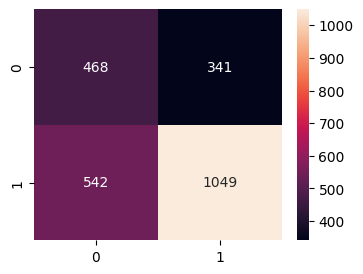

In [31]:
plt.figure(figsize=(4,3))
matrix = confusion_matrix(y_true=y_test, y_pred=bow_prediction)
sns.heatmap(matrix, annot=True, fmt='1.0f')

### Evaluating TF-IDF Model

In [32]:
accuracy = accuracy_score(y_true=y_test, y_pred=tfidf_prediction)
precision = precision_score(y_true=y_test, y_pred=tfidf_prediction)
recall = recall_score(y_true=y_test, y_pred=tfidf_prediction)
f1 = f1_score(y_true=y_test, y_pred=tfidf_prediction)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.5941666666666666
Precision: 0.7502027575020276
Recall: 0.5813953488372093
F1-Score: 0.6550991501416431


In [33]:
print(classification_report(y_true=y_test, y_pred=tfidf_prediction))

              precision    recall  f1-score   support

           0       0.43      0.62      0.51       809
           1       0.75      0.58      0.66      1591

    accuracy                           0.59      2400
   macro avg       0.59      0.60      0.58      2400
weighted avg       0.64      0.59      0.61      2400



<Axes: >

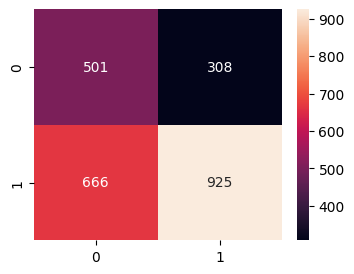

In [34]:
plt.figure(figsize=(4,3))
matrix = confusion_matrix(y_true=y_test, y_pred=tfidf_prediction)
sns.heatmap(matrix, annot=True, fmt='1.0f')